## Imports

In [ ]:
import configparser

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col

from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType,StructType, StructField

import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
from snowflake.ml.modeling.impute import SimpleImputer

import json

import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
my_dir = os.getcwd()
connection_parameters = json.load(open(f'{my_dir}/creds.json'))
session = Session.builder.configs(connection_parameters).create()

# <font color='red'>Snowpark with Big Data</font>

In [4]:
snow_df = session.table('CITIBIKEML_JACK.DEMO.TRIPS')

In [5]:
snow_df

In [6]:
%%time
snow_df.limit(5).to_pandas()

CPU times: user 18.8 ms, sys: 11.1 ms, total: 29.9 ms
Wall time: 886 ms


,START_STATION_NAME,START_STATION_ID,END_STATION_NAME,END_STATION_ID,START_STATION_LATITUDE,START_STATION_LONGITUDE,END_STATION_LATITUDE,END_STATION_LONGITUDE,USERTYPE,STARTTIME,STOPTIME
0,E 39 St & 2 Ave,518,E 40 St & 5 Ave,153,40.74780373,-73.9734419,40.752062307,-73.9816324043,Subscriber,2014-08-06 10:05:43,2014-08-06 10:11:33
1,St James Pl & Pearl St,82,Fulton St & William St,316,40.71117416,-74.00016545,40.70955958,-74.00653609,Subscriber,2014-08-06 10:05:46,2014-08-06 10:10:00
2,Washington St & Gansevoort St,405,W 4 St & 7 Ave S,380,40.739323,-74.008119,40.73401143,-74.00293877,Subscriber,2014-08-06 10:06:58,2014-08-06 10:11:43
3,E 43 St & Vanderbilt Ave,318,W 42 St & 8 Ave,529,40.75320159,-73.9779874,40.7575699,-73.99098507,Subscriber,2014-08-06 10:06:58,2014-08-06 10:15:11
4,Broadway & W 29 St,486,Dean St & 4 Ave,467,40.7462009,-73.98855723,40.68312489,-73.97895137,Subscriber,2014-08-06 10:23:39,2014-08-06 10:53:26


In [7]:
%%time
print('Size of the Snowpark DF: ', snow_df.count())

Size of the Snowpark DF:  103835123
CPU times: user 4.81 ms, sys: 2.08 ms, total: 6.9 ms
Wall time: 378 ms


In [8]:
%%time
pandas_df = snow_df.with_column("date", F.to_date("STARTTIME")).group_by("date").count().sort("date").to_pandas()

CPU times: user 22.8 ms, sys: 4.68 ms, total: 27.5 ms
Wall time: 960 ms


In [8]:
pandas_df

,DATE,COUNT
0,2013-06-01,8721
1,2013-06-02,15971
2,2013-06-03,7598
3,2013-06-04,15782
4,2013-06-05,15690
...,...,...
2636,2020-08-27,69313
2637,2020-08-28,78167
2638,2020-08-29,71287
2639,2020-08-30,92434


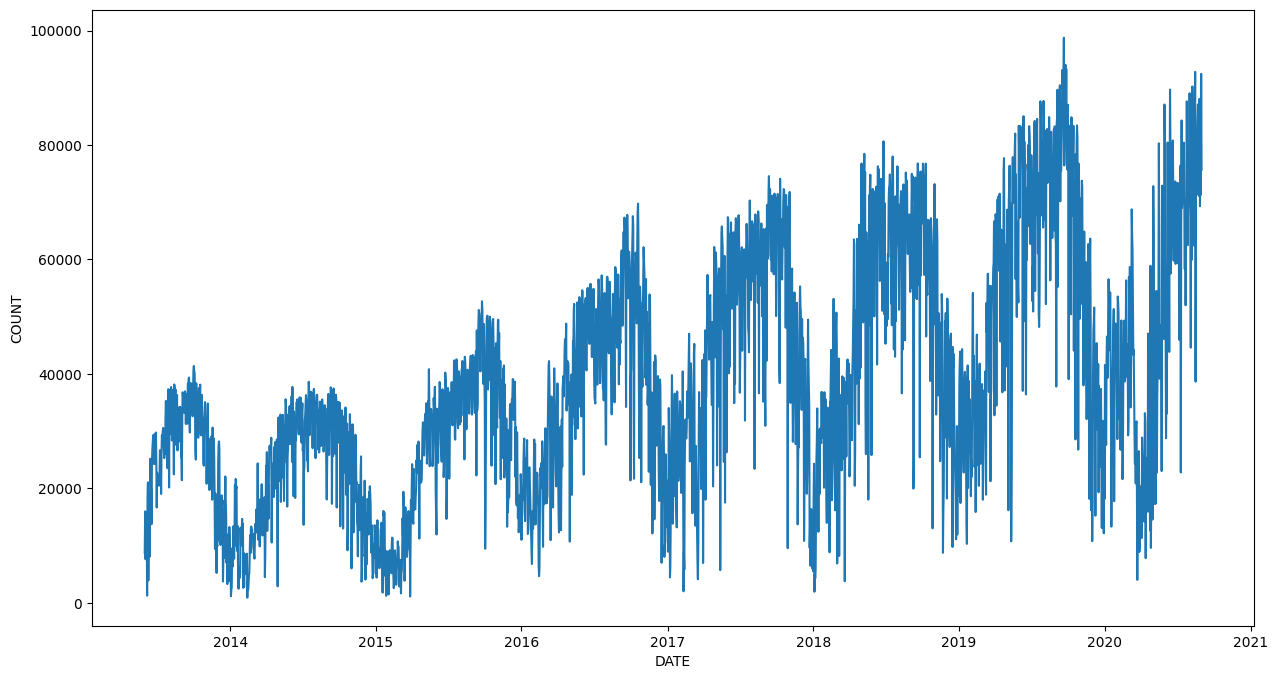

In [9]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=pandas_df)

#  
#  
# 
 
# <font color='red'>Snowpark for ML</font>

## 1.0 Prepare Data 

In [17]:
session.sql('ALTER WAREHOUSE SSK_RESEARCH SET WAREHOUSE_SIZE = "MEDIUM"').collect()

[Row(status='Statement executed successfully.')]

In [6]:
session.use_database('DEMO_DB')
session.use_schema('PUBLIC')

In [19]:
# Creating a Snowpark DataFrame
application_record_sdf = session.table('APPLICATION_RECORD')
credit_record_sdf = session.table('CREDIT_RECORD')
print('Application table size\t: ',application_record_sdf.count(), 
      '\nCredit table size\t: ', credit_record_sdf.count())

Application table size	:  438557 
Credit table size	:  1048575


In [20]:
credit_record_sdf.limit(5).to_pandas()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [21]:
# We will create a new column, TARGET, that will have a 1 for high-risk and 0 for low-risk.
credit_record_sdf = credit_record_sdf.group_by('ID')\
                        .agg(F.sum(F.iff(F.col('STATUS').in_(['2', '3','4','5']), 1, 0)).as_("CNT_LATE"))\
                        .with_column('TARGET', F.when(F.col('CNT_LATE') > 0, 1).otherwise(0)).drop("CNT_LATE")

In [22]:
# Join Credit Record data with Application Record Data
joined_sdf = application_record_sdf.join(credit_record_sdf, using_columns='ID', join_type='inner')

In [23]:
# Duplicate Removal - Use the **drop_duplicates** to remove duplicated rows
joined_sdf = joined_sdf.drop_duplicates('ID')

In [24]:
joined_sdf.count()

36457

In [25]:
# Selecting a few columns for modeling
cols_numerical = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'CNT_FAM_MEMBERS', 'TARGET']
cols_categorical = ['CODE_GENDER', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
joined_sdf = joined_sdf[cols_numerical+cols_categorical]

In [26]:
joined_sdf.limit(10).to_pandas()

,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_MOBIL,CNT_FAM_MEMBERS,TARGET,CODE_GENDER,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,67500.0,-213,1,4.0,0,F,With parents,Core staff
1,90000.0,-1536,1,2.0,0,F,Rented apartment,Core staff
2,202500.0,-127,1,3.0,0,M,House / apartment,Laborers
3,112500.0,-1508,1,3.0,0,M,House / apartment,Drivers
4,135000.0,-4428,1,2.0,0,F,House / apartment,Managers
5,202500.0,-3166,1,2.0,0,F,House / apartment,Sales staff
6,157500.0,-3078,1,1.0,0,F,House / apartment,Managers
7,126000.0,-5553,1,2.0,0,M,House / apartment,None
8,360000.0,-2475,1,3.0,0,F,House / apartment,None
9,270000.0,-2408,1,2.0,0,F,House / apartment,None


In [27]:
joined_sdf

In [28]:
# Perform One-Hot-Encoding for categorical columns
my_ohe_encoder = OneHotEncoder(input_cols=cols_categorical, output_cols=cols_categorical, drop_input_cols=True)
prepared_sdf = my_ohe_encoder.fit(joined_sdf).transform(joined_sdf)

In [29]:
prepared_sdf.columns

['CODE_GENDER_F',
 'CODE_GENDER_M',
 '"NAME_HOUSING_TYPE_Co-op apartment"',
 '"NAME_HOUSING_TYPE_House / apartment"',
 '"NAME_HOUSING_TYPE_Municipal apartment"',
 '"NAME_HOUSING_TYPE_Office apartment"',
 '"NAME_HOUSING_TYPE_Rented apartment"',
 '"NAME_HOUSING_TYPE_With parents"',
 '"OCCUPATION_TYPE_Accountants"',
 '"OCCUPATION_TYPE_Cleaning staff"',
 '"OCCUPATION_TYPE_Cooking staff"',
 '"OCCUPATION_TYPE_Core staff"',
 '"OCCUPATION_TYPE_Drivers"',
 '"OCCUPATION_TYPE_HR staff"',
 '"OCCUPATION_TYPE_High skill tech staff"',
 '"OCCUPATION_TYPE_IT staff"',
 '"OCCUPATION_TYPE_Laborers"',
 '"OCCUPATION_TYPE_Low-skill Laborers"',
 '"OCCUPATION_TYPE_Managers"',
 '"OCCUPATION_TYPE_Medicine staff"',
 '"OCCUPATION_TYPE_Private service staff"',
 '"OCCUPATION_TYPE_Realty agents"',
 '"OCCUPATION_TYPE_Sales staff"',
 '"OCCUPATION_TYPE_Secretaries"',
 '"OCCUPATION_TYPE_Security staff"',
 '"OCCUPATION_TYPE_Waiters/barmen staff"',
 '"OCCUPATION_TYPE_None"',
 'AMT_INCOME_TOTAL',
 'DAYS_EMPLOYED',
 'FLAG_MO

In [30]:
prepared_sdf.limit(5).to_pandas()

,CODE_GENDER_F,CODE_GENDER_M,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,...,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_None,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_MOBIL,CNT_FAM_MEMBERS,TARGET
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,67500.0,-1586,1,2.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,126000.0,-157,1,3.0,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,216000.0,365243,1,1.0,0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,315000.0,-2851,1,3.0,0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,270000.0,365243,1,2.0,0


In [31]:
prepared_sdf

In [32]:
# Cleaning column names to make it easier for future referencing
import re

cols = prepared_sdf.columns
for old_col in cols:
    new_col = re.sub(r'[^a-zA-Z0-9_]', '', old_col)
    new_col = new_col.upper()
    prepared_sdf = prepared_sdf.rename(col(old_col), new_col)

In [33]:
# Split the data and save the train and test sets as tables in Snowflake
snowdf_train, snowdf_test = prepared_sdf.random_split([0.8, 0.2], seed=82) 
snowdf_train.write.mode("overwrite").save_as_table("CREDIT_DEFAULT_TRAIN")
snowdf_test.write.mode("overwrite").save_as_table("CREDIT_DEFAULT_TEST")

## 2.0 ML Modeling

In [7]:
# Prepare Data for modeling
snowdf_train = session.table('DEMO_DB.PUBLIC.CREDIT_DEFAULT_TRAIN')
feature_cols = snowdf_train.columns
feature_cols.remove('TARGET')
target_col = 'TARGET'

In [8]:
snowdf_train.limit(5).to_pandas()

,CODE_GENDER_F,CODE_GENDER_M,NAME_HOUSING_TYPE_COOPAPARTMENT,NAME_HOUSING_TYPE_HOUSEAPARTMENT,NAME_HOUSING_TYPE_MUNICIPALAPARTMENT,NAME_HOUSING_TYPE_OFFICEAPARTMENT,NAME_HOUSING_TYPE_RENTEDAPARTMENT,NAME_HOUSING_TYPE_WITHPARENTS,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CLEANINGSTAFF,...,OCCUPATION_TYPE_SALESSTAFF,OCCUPATION_TYPE_SECRETARIES,OCCUPATION_TYPE_SECURITYSTAFF,OCCUPATION_TYPE_WAITERSBARMENSTAFF,OCCUPATION_TYPE_NONE,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_MOBIL,CNT_FAM_MEMBERS,TARGET
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,67500.0,-1586,1,2.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,126000.0,-157,1,3.0,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,216000.0,365243,1,1.0,0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,315000.0,-2851,1,3.0,0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,270000.0,365243,1,2.0,0


In [9]:
# Define the XGBClassifier and fit the model
from snowflake.ml.modeling.xgboost import XGBClassifier

xgbmodel = XGBClassifier(random_state=123, input_cols=feature_cols, label_cols=target_col, output_cols='PREDICTION')
xgbmodel.fit(snowdf_train)

The version of package 'snowflake-snowpark-python' in the local environment is 1.10.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.


In [37]:
# Score the data using the fitted xgbmodel
snowdf_test = session.table('CREDIT_DEFAULT_TEST')
scored_sdf = xgbmodel.predict(snowdf_test)

In [38]:
snowdf_test.count()

7107

In [39]:
scored_sdf.limit(5).to_pandas()

,FLAG_MOBIL,NAME_HOUSING_TYPE_COOPAPARTMENT,NAME_HOUSING_TYPE_MUNICIPALAPARTMENT,OCCUPATION_TYPE_REALTYAGENTS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_ITSTAFF,OCCUPATION_TYPE_WAITERSBARMENSTAFF,OCCUPATION_TYPE_MEDICINESTAFF,OCCUPATION_TYPE_HRSTAFF,OCCUPATION_TYPE_LOWSKILLLABORERS,...,NAME_HOUSING_TYPE_HOUSEAPARTMENT,NAME_HOUSING_TYPE_OFFICEAPARTMENT,OCCUPATION_TYPE_SECURITYSTAFF,AMT_INCOME_TOTAL,TARGET,OCCUPATION_TYPE_CLEANINGSTAFF,CODE_GENDER_F,OCCUPATION_TYPE_HIGHSKILLTECHSTAFF,DAYS_EMPLOYED,PREDICTION
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,157500.0,0,0.0,1.0,0.0,-8376,0
1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,315000.0,0,0.0,1.0,0.0,-4064,0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,157500.0,0,0.0,1.0,0.0,-737,0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,117000.0,0,0.0,1.0,0.0,-4852,0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,270000.0,0,0.0,1.0,1.0,-2164,0


In [10]:
!pip list

Package                    Version
-------------------------- ---------
absl-py                    1.4.0
adagio                     0.2.4
aiobotocore                2.5.4
aiohttp                    3.8.5
aioitertools               0.11.0
aiosignal                  1.3.1
antlr4-python3-runtime     4.11.1
antropy                    0.1.6
anyio                      3.7.1
appdirs                    1.4.4
appnope                    0.1.3
arch                       6.2.0
argon2-cffi                23.1.0
argon2-cffi-bindings       21.2.0
arrow                      1.2.3
asn1crypto                 1.5.1
asttokens                  2.4.0
astunparse                 1.6.3
async-lru                  2.0.4
async-timeout              4.0.3
attrs                      23.1.0
Babel                      2.12.1
backcall                   0.2.0
beautifulsoup4             4.12.2
bleach                     6.0.0
botocore                   1.31.17
cachetools                 4.2.4
certifi                    2

In [40]:
# Calculate Metrics
from snowflake.ml.modeling.metrics import f1_score, accuracy_score
F1 = f1_score(df = scored_sdf,
              y_true_col_names = 'TARGET',
              y_pred_col_names = 'PREDICTION')
ACCURACY = accuracy_score(df = scored_sdf,
                          y_true_col_names = 'TARGET',
                          y_pred_col_names = 'PREDICTION')
print(f'F1 Score: {F1} \nAccuracy Score: {ACCURACY}')

DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


F1 Score: 0.036036036036036036 
Accuracy Score: 0.984944


In [41]:
# Write the outputs to a Snowflake Table
scored_sdf.write.save_as_table(table_name='SCORED_CREDIT_RISK', mode='overwrite')

## Deploying Model for Future Use

Steps to follow-
1. Get model in your local environment
2. Save the file in your local env. as .joblib file
3. Upload the file to Snowflake stage
4. Create UDF using model in stage

We can use `to_xgboost()` in order to get the actual xgboost model object which gives us access to all its attributes.

### Step 1 - 3:
1. Get model in your local environment
2. Save the file in your local env. as .joblib file
3. Upload the file to Snowflake stage

In [42]:
import joblib
import cachetools

In [43]:
# Step 1
xgb_file = xgbmodel.to_xgboost()
xgb_file

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [ ]:
# Step 2
MODEL_FILE = 'model.joblib.gz'
joblib.dump(xgb_file, MODEL_FILE) # we are just pickling it locally first

In [ ]:
# Step 3
# You can also save the pickled object into the stage we created earlier
session.file.put(MODEL_FILE, "@ML_MODELS", auto_compress=False, overwrite=True)

### Step 4

Create a UDF for future reference


In [ ]:
import pandas as pd
from snowflake.snowpark.functions import udf
import snowflake.snowpark.types as T

In [ ]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_xgboost_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'model.joblib.gz'
    model = load_model(import_dir+model_name)
    df.columns = feature_cols
    scored_data = pd.Series(model.predict(df))
    return scored_data

In [ ]:
# Register UDF
udf_clv = session.udf.register(func=udf_score_xgboost_model_vec_cached, 
                               name="PREDICT_DEFAULT", 
                               stage_location='@ML_MODELS',
                               input_types=[T.FloatType()]*len(feature_cols),
                               return_type = T.FloatType(),
                               replace=True, 
                               is_permanent=True, 
                               imports=['@ML_MODELS/model.joblib.gz'],
                               packages=['pandas',
                                         'xgboost',
                                         'joblib',
                                         'cachetools'], 
                               session=session)

### Step 5 Extra Stuff

### Inference using UDF Created right here

Note we are using `udf_clv` that was defined earlier.

In [ ]:
test_sdf_w_preds = snowdf_test.with_column('PREDICTED', udf_clv(*feature_cols))
test_sdf_w_preds.limit(2).to_pandas()

### Inference using UDF Called from Snowflake

Notice we are calling the UDF created in snowflake using `F.call_udf()`

In [ ]:
snowdf_test = session.table('CREDIT_DEFAULT_TEST')
feature_cols = snowdf_test.columns
target_col = 'TARGET'
feature_cols.remove(target_col)
test_sdf_w_preds = snowdf_test.with_column('PREDICTED', F.call_udf("PREDICT_DEFAULT",
                                                                   [F.col(c) for c in feature_cols]))
test_sdf_w_preds.limit(5).to_pandas()

# Want to Deploy and Schedule Your Code?

In [ ]:
from snowflake.core import Root
from snowflake.core.task import StoredProcedureCall, Task
from snowflake.core.task.dagv1 import DAGOperation, DAG, DAGTask
from datetime import date, timedelta

In [ ]:
api_root = Root(session)

In [ ]:
def func_forecasting(session:Session) -> str:
    session.sql('Data cleaning').collect()
    session.sql('''CREATE SNOWFLAKE.ML.FORECAST model2(INPUT_DATA => SYSTEM$REFERENCE('VIEW', 'HACKATHON.INVISTA.TS_MULTI'),
                                    SERIES_COLNAME => 'MEMBER_ID',
                                    TIMESTAMP_COLNAME => 'BUS_DT',
                                    TARGET_COLNAME => 'LIQ_NEED'
                                    )''').collect()
    session.sql('''call model2!FORECAST(FORECASTING_PERIODS => 30);''').collect()
    session.sql('''insert into table''').collect()



In [ ]:
def func_forecasting(session:Session) -> str:
        df_input = pd.concat(self.dfs)
        df_input['DATE'] = pd.to_datetime(df_input['DATE'])
        df_input.groupby(['DATE','SERIES_ID']).sum('VALUE').reset_index()
        df_input = df_input[['DATE','SERIES_ID','VALUE']]
        df_input.columns = ['ds','unique_id','y']

        #Train + Forecast Length
        train_length = 600
        fh = 30 # Forecast Horizon
        train_end = max(df_input['ds'])
        train_start = train_end - pd.Timedelta(days = 600)
        
        df_input = df_input.loc[(df_input['ds'] >= train_start) &
                                (df_input['ds'] < train_end)].reset_index(drop=True)

        
        fcst = MLForecast(models=[LinearRegression(),XGBRegressor()],
                          freq='D',
                          lags=[1,7,28,60],
                          target_transforms=[Differences([1])])
        
        fcst.fit(df_mlf.iloc[0:-fh])

        ts_forecast = fcst.predict(fh)
        
        # Processing
        ts_forecast.columns = ['ID','TIMESTAMP','LINREG','XGB']
        ts_forecast['TRAIN_START'] = train_start
        ts_forecast['TRAIN_END'] = train_end
        ts_forecast['FORECAST_HORIZON'] = fh
    session.write('')



In [ ]:
# Process Input
        df_input = pd.concat(self.dfs)
        df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
        df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
        df_input = df_input[['TIMESTAMP','VALUE']]

        #Train + Forecast Length
        train_length = 600
        forecast_horizon = 30
        train_end = max(df_input['TIMESTAMP'])
        train_start = train_end - pd.Timedelta(days = 600)
        
        df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                                (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)
        df_input = df_input.set_index('TIMESTAMP')
        df_input.index.name = 'time'
        
        # Convert DataFrame to Darts TS Object
        ts_train = TimeSeries.from_dataframe(df_input, fill_missing_dates=True, freq='D')
        
        # Initialize Model
        my_model = XGBModel(lags = 10, n_estimators=100, max_depth=5)

        # Fit Model and Predict
        my_model.fit(ts_train)
        ts_forecast = my_model.predict(forecast_horizon)
        
        # Processing
        data = ts_forecast.pd_dataframe().reset_index().values
        df_forecast = pd.DataFrame(data, columns = ['TIMESTAMP','VALUE'])
        df_forecast['TRAIN_START'] = train_start
        df_forecast['TRAIN_END'] = train_end
        df_forecast['FORECAST_HORIZON'] = forecast_horizon

In [ ]:
# Task 1 stuff
task1_entity = Task(
    "forecasting_pipe",
    definition=StoredProcedureCall(func_forecasting, stage_location="@ML_MODELS", packages=["snowflake-snowpark-python","snowflake-ml-python", "regex"]),
    warehouse='SSK_RESEARCH',
    schedule=timedelta(days=1))

task1 = tasks.create(task1_entity, mode="orReplace")

In [ ]:
def func_data_preprocess_pipeline(session:Session) -> str:
    import snowflake.snowpark.functions as F
    from snowflake.snowpark.functions import udf
    from snowflake.ml.modeling.preprocessing import OneHotEncoder
    import re
    
    session.use_database('DEMO_DB')
    session.use_schema('PUBLIC')

    # Creating a Snowpark DataFrame
    application_record_sdf = session.table('APPLICATION_RECORD')
    credit_record_sdf = session.table('CREDIT_RECORD')

    # We will create a new column, TARGET, that will have a 1 for high-risk and 0 for low-risk.
    credit_record_sdf = credit_record_sdf.group_by('ID')\
                            .agg(F.sum(F.iff(F.col('STATUS').in_(['2', '3','4','5']), 1, 0)).as_("CNT_LATE"))\
                            .with_column('TARGET', F.when(F.col('CNT_LATE') > 0, 1).otherwise(0)).drop("CNT_LATE")

    
    # Join Credit Record data with Application Record Data
    joined_sdf = application_record_sdf.join(credit_record_sdf, using_columns='ID', join_type='inner')
    # Duplicate Removal - Use the **drop_duplicates** to remove duplicated rows
    joined_sdf = joined_sdf.drop_duplicates('ID')

    # Selecting a few columns for modeling
    cols_numerical = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'CNT_FAM_MEMBERS', 'TARGET']
    cols_categorical = ['CODE_GENDER', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
    joined_sdf = joined_sdf[cols_numerical+cols_categorical]

    # Perform One-Hot-Encoding for categorical columns
    my_ohe_encoder = OneHotEncoder(input_cols=cols_categorical, output_cols=cols_categorical, drop_input_cols=True)
    prepared_sdf = my_ohe_encoder.fit(joined_sdf).transform(joined_sdf)

    cols = prepared_sdf.columns
    for old_col in cols:
        new_col = re.sub(r'[^a-zA-Z0-9_]', '', old_col)
        new_col = new_col.upper()
        prepared_sdf = prepared_sdf.rename(col(old_col), new_col)

    # Save the data as table in Snowflake
    prepared_sdf.write.mode("overwrite").save_as_table("PIPE_CREDIT_DEFAULT")
    
    return f"Preprocessing pipeline ran successfully"

In [ ]:
def func_inference_pipeline(session:Session) -> str:
    import snowflake.snowpark.functions as F
    snowdf_test = session.table('PIPE_CREDIT_DEFAULT')
    feature_cols = snowdf_test.columns
    target_col = 'TARGET'
    feature_cols.remove(target_col)
    test_sdf_w_preds = snowdf_test.with_column('PREDICTED', F.call_udf("PREDICT_DEFAULT",
                                                                       [F.col(c) for c in feature_cols]))
    test_sdf_w_preds.write.mode("overwrite").save_as_table("SCORED_CREDIT_RISK")
    return f"Inference pipeline ran successfully"

#### Setup Tasks

In [ ]:
schema = api_root.databases['DEMO_DB'].schemas['PUBLIC']
tasks = schema.tasks

In [ ]:
# Task 1 stuff
task1_entity = Task(
    "preprocess_pipeline",
    definition=StoredProcedureCall(func_data_preprocess_pipeline, stage_location="@ML_MODELS", packages=["snowflake-snowpark-python","snowflake-ml-python", "regex"]),
    warehouse='SSK_RESEARCH',
    schedule=timedelta(days=1))

task1 = tasks.create(task1_entity, mode="orReplace")

In [ ]:
# Task 2 stuff
task2_entity = Task(
    "inference_pipeline",
    definition=StoredProcedureCall(func_inference_pipeline, stage_location="@ML_MODELS", packages=["snowflake-snowpark-python"]),
    warehouse='SSK_RESEARCH')

task2_entity.predecessors = ["DEMO_DB.PUBLIC.PREPROCESS_PIPELINE"]
task2 = tasks.create(task2_entity, mode="orReplace")

In [ ]:
task2.resume()
task1.resume()